In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

query = '''SELECT
user_id,
exp_group,
sum(action = 'like') AS likes,
sum(action = 'view') AS views,
sum(action = 'like')/sum(action = 'view') AS ctr
FROM simulator_20230420.feed_actions
WHERE exp_group in(1,2)
AND toDate(time) BETWEEN '2023-04-01' AND '2023-04-07'
GROUP BY user_id,exp_group'''


In [3]:

df = pandahouse.read_clickhouse(query, connection=connection)


In [4]:
control = df.query('exp_group==1').ctr
test    = df.query('exp_group==2').ctr

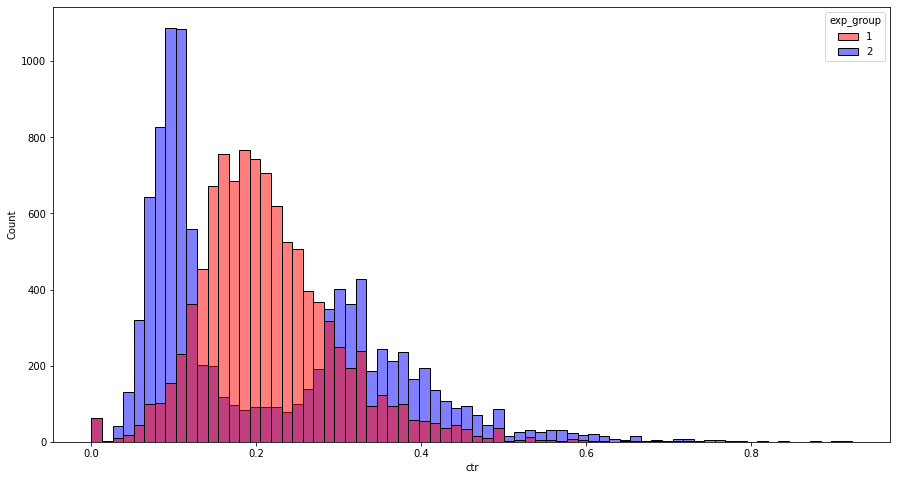

In [5]:
# Распределение ctr выглядит сильно ненормальным для группы 2.
plt.figure(figsize=(15,8))
sns.histplot(data=df,x='ctr', hue='exp_group',palette = ['r', 'b'])
plt.show()

In [6]:
# Проведем тест Шапиро-Уилка на нормальность распределения в группах
stats.shapiro(test) # В тестовой группе распределение ненормальное(pvalue < 0.05)

/nfs/env/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.8864326477050781, pvalue=0.0)

In [7]:
stats.shapiro(control) # В  контрольной группе распределение ненормальное(pvalue < 0.05)

ShapiroResult(statistic=0.9498439431190491, pvalue=0.0)

In [8]:
# Однако,для т-теста нам важнее как распределено выборочное среднее в группах(нужно его нормальное распределение). 
# Для этого воспользуемся бутстрапом, готовым кодом с Githab(https://gist.github.com/KIRILLxBREAK/4010dd4eaf45a2203cb28251ce099329#file-bootstrap_check_normality-py).

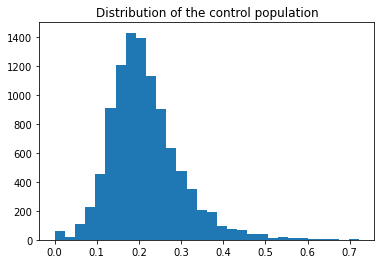

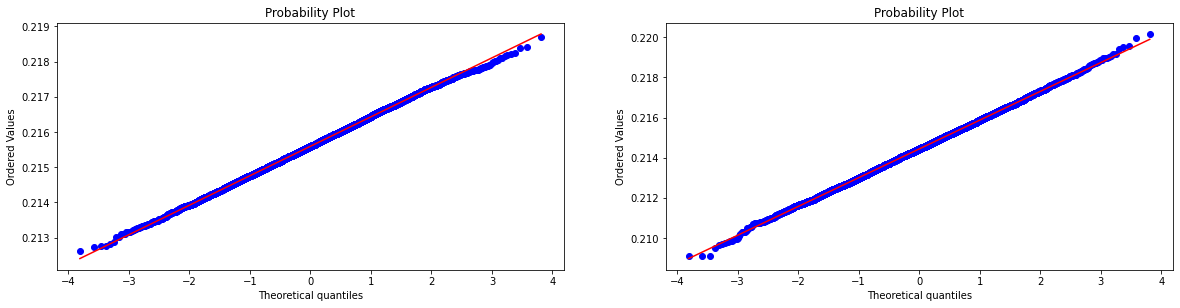

Тест на нормальность распределения control группы: W = 1.000 , p-value = 0.146 => не стат значимо, нормальное
Тест на нормальность распределения test группы: W = 1.000 , p-value = 0.565 => не стат значимо, нормальное


/nfs/env/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [9]:
sample_means_control = []
sample_means_test = []
for i in range(10000):
  sample_control = control.sample(frac=1, replace=True)
  sample_test = test.sample(frac=1, replace=True)
  sample_means_control.append(sample_control.mean())
  sample_means_test.append(sample_test.mean())
  
# Plot the population
count, bins, ignored = plt.hist(sample_control, 30)
plt.title('Distribution of the control population')
plt.show()
# Q-Q plots for control and target groups
pylab.figure(figsize=(20,10))
pylab.subplot(2,2,1)
stats.probplot(sample_means_control, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(sample_means_test, dist="norm", plot=pylab)
pylab.show()

# check for normality by Shapiro-Wilk test
sp = stats.shapiro(sample_means_control)
concl = '=> не стат значимо, нормальное' if sp[1]>0.05 else '=> стат значимо не нормально' 
print('Тест на нормальность распределения control группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)

sp = stats.shapiro(sample_means_test)
concl = '=> не стат значимо, нормальное' if sp[1]>0.05 else '=> стат значимо не нормально' 
print('Тест на нормальность распределения test группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)

In [10]:
# Выборочное среднее распределено нормально, а это значит, что мы можем проводить т-тест на полученных данных.

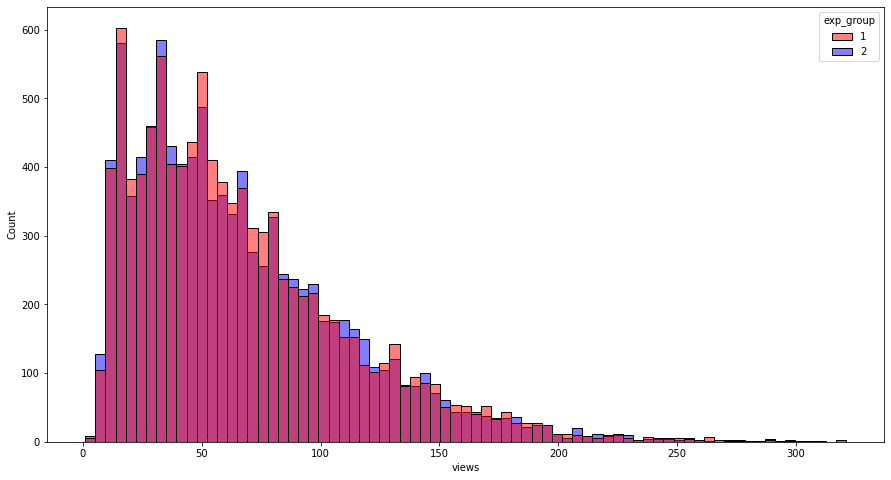

In [11]:
# посмотрим на распределение просмотров
plt.figure(figsize=(15,8))
sns.histplot(data=df,x='views', hue='exp_group',palette = ['r', 'b'])
plt.show()

In [12]:
# Просмотры распределены равномерно для обеих групп.
# Довольно много юзеров(14%) имеют небольшое количество просмотров(меньше 20),
# т.е. нельзя быть уверенным в правильном расчете  ctr для этих пользователей.
round(df.query('views<20').user_id.count()/df.query('views>=20').user_id.count()*100)

14

In [13]:
# Основываясь на полученных результатах(возможность проведения т-теста, но наличие юзеров с малым количеством просмотров)
# я выберу метод исследования т-тест на сглаженном ctr

In [14]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_control = df.query('exp_group == 1').likes.sum()/df.query('exp_group == 1').views.sum()
global_ctr_test    = df.query('exp_group == 2').likes.sum()/df.query('exp_group == 2').views.sum()

control_gr = df.query('exp_group == 1').copy()
test_gr    = df.query('exp_group == 2').copy()
control_gr['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_control, 5), axis=1)
test_gr['smothed_ctr']    = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_test, 5), axis=1)

test_smothed_ctr = stats.ttest_ind(control_gr['smothed_ctr'],test_gr['smothed_ctr'],
                                   equal_var=False)


In [15]:
# т-тест показывает статистически значимое различие для 1 и 2 групп (pvalue < 0.05). 
# Однако,в тестовой группе ctr меньше,чем в контрольной
test_smothed_ctr

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

Проведение нескольких разных тестов на одних и тех же данных увеличивает возможность возникновения ошибки интерпретации тестов.
В своей работе я бы остановилась на проведении т-теста на сглаженном ctr и по результатам сделала бы следующие выводы:

Эксперимент показал снижение CTR в тестовой группе, так что раскатывать алгоритм в данном виде на всех новых пользователей точно не стоит. Однако, распределение CTR в тестовой группе имеет 2 моды, это значит,что пользователи отреагировали на новый алгоритм: одним пользователям продукт стал нравится меньше,а другим больше. Возможно, стоит повнимательнее изучить пользователей,которые положительно отреагировали на новый алгоритм,и,если есть закономерности,изучить действие нового алгоритма для них. Либо, можно продолжить работу с алгоритмом и улучшить его так,чтобы он подходил большему числу пользователей.